# Importing Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import tensorflow as tf
import matplotlib.patches as mpatches

# Loading Dataset

In [2]:
!unzip /content/archive.zip

Archive:  /content/archive.zip
  inflating: datasets/annotations/a (1).xml  
  inflating: datasets/annotations/a (10).xml  
  inflating: datasets/annotations/a (100).xml  
  inflating: datasets/annotations/a (101).xml  
  inflating: datasets/annotations/a (102).xml  
  inflating: datasets/annotations/a (103).xml  
  inflating: datasets/annotations/a (104).xml  
  inflating: datasets/annotations/a (105).xml  
  inflating: datasets/annotations/a (106).xml  
  inflating: datasets/annotations/a (107).xml  
  inflating: datasets/annotations/a (108).xml  
  inflating: datasets/annotations/a (109).xml  
  inflating: datasets/annotations/a (11).xml  
  inflating: datasets/annotations/a (110).xml  
  inflating: datasets/annotations/a (111).xml  
  inflating: datasets/annotations/a (112).xml  
  inflating: datasets/annotations/a (12).xml  
  inflating: datasets/annotations/a (13).xml  
  inflating: datasets/annotations/a (14).xml  
  inflating: datasets/annotations/a (15).xml  
  inflating: data

In [3]:
# Define Directory
images_directory = "/content/datasets/images"
annotations_directory="/content/datasets/annotations"

img_paths = sorted([os.path.join(images_directory, fname) for fname in os.listdir(images_directory) if fname.endswith(".jpg")])
label_paths = sorted([os.path.join(annotations_directory, fname) for fname in os.listdir(annotations_directory) if fname.endswith(".xml")])

k = len(img_paths)

data_list = []

for i in range(k):
    annotation_file=label_paths[i]
    ds = BeautifulSoup(open(annotation_file).read(), "html.parser")

    # Iterating over each object elements
    for o in ds.find_all("object"):

        x_min = max(0, int(float(o.find("xmin").string)))
        y_min = max(0, int(float(o.find("ymin").string)))
        x_max = min(int(ds.find("width").string), int(float(o.find("xmax").string)))
        y_max = min(int(ds.find("height").string), int(float(o.find("ymax").string)))

        # in case the boundary goes above its limis, providing some restrictions.
        if x_min >= x_max or y_min >= y_max:
            continue
        elif x_max <= x_min or y_max <= y_min:
            continue

        sample = [str(img_paths[i]), x_min, y_min, x_max, y_max]

        data_list.append(sample)

data = pd.DataFrame(data_list)

# EDA

In [4]:
data.head()

,0,1,2,3,4
0,/content/datasets/images/a (1).jpg,38,54,179,173
1,/content/datasets/images/a (10).jpg,58,14,155,117
2,/content/datasets/images/a (100).jpg,86,18,182,125
3,/content/datasets/images/a (101).jpg,23,16,120,115
4,/content/datasets/images/a (102).jpg,33,30,166,173


xmin 38 ymin 54 xmax 179 ymax 173


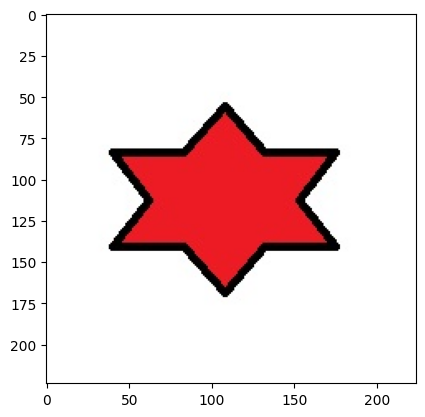

In [5]:
img = plt.imread(data[0][0])
plt.imshow(img)
print('xmin', data[1][0], 'ymin',data[2][0],'xmax',data[3][0],'ymax',data[4][0])

In [6]:
print(img.shape)

(224, 224, 3)


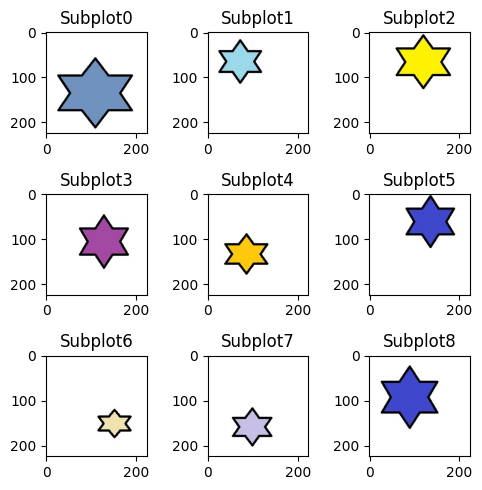

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Define parameters
width = 5
height = 5
rows = 3
cols = 3
axes = []

# Create figure
fig = plt.figure(figsize=(width, height))

# Plot images
for a in range(rows * cols):
    c = np.random.randint(100)
    img = plt.imread(data[0][c])
    axes.append(fig.add_subplot(rows, cols, a + 1))
    subplot_title = "Subplot" + str(a)
    axes[-1].set_title(subplot_title)
    plt.imshow(img)

# Adjust layout
fig.tight_layout()

# Save the plot
plt.savefig('plot.png')

# Show the plot (optional)
plt.show()


x_min samples

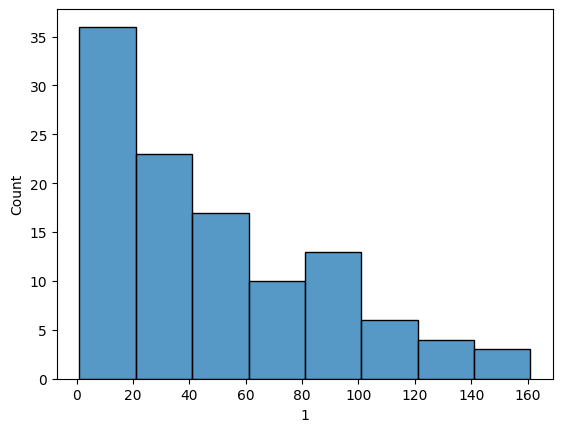

In [9]:
sns.histplot(data[1])


# Save the plot
plt.savefig('histogram-xmin.png')

# Show the plot (optional)
plt.show()

y_min samples

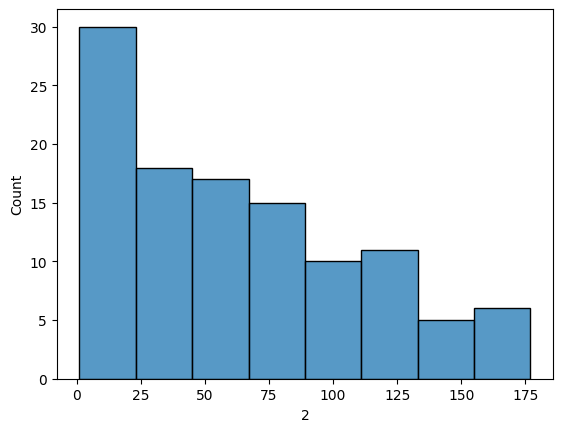

In [10]:
sns.histplot(data[2])
# Save the plot
plt.savefig('histogram-ymin.png')

# Show the plot (optional)
plt.show()

x_max samples

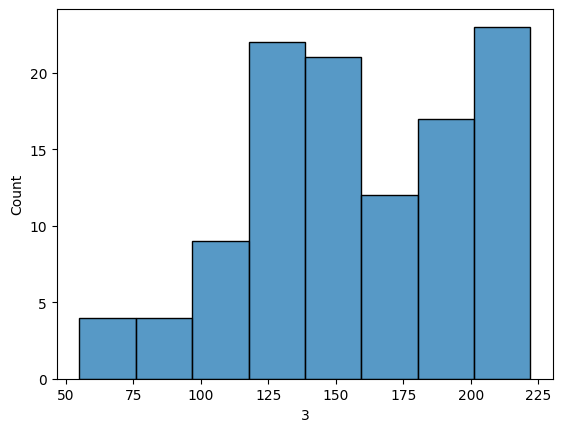

In [11]:
sns.histplot(data[3])
# Save the plot
plt.savefig('histogram-xmax.png')

# Show the plot (optional)
plt.show()

y_max samples

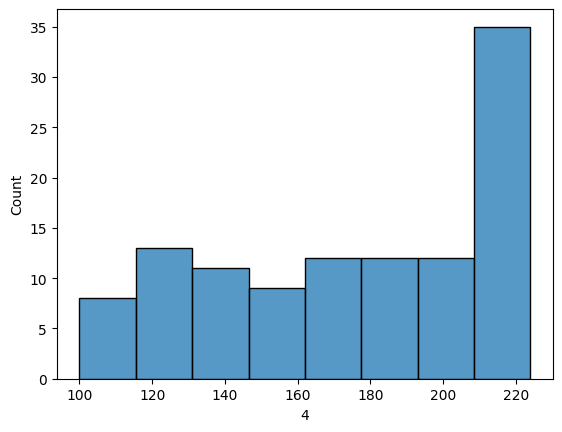

In [12]:
sns.histplot(data[4])
# Save the plot
plt.savefig('histogram-ymax.png')

# Show the plot (optional)
plt.show()

In [16]:
import pandas as pd

def cm(xmin, xmax):
    return (xmin + xmax) / 2

# Apply the cm function to calculate the center x and y coordinates
data['cx'] = data.apply(lambda r: cm(r[1], r[3]), axis=1)
data['cy'] = data.apply(lambda r: cm(r[2], r[4]), axis=1)


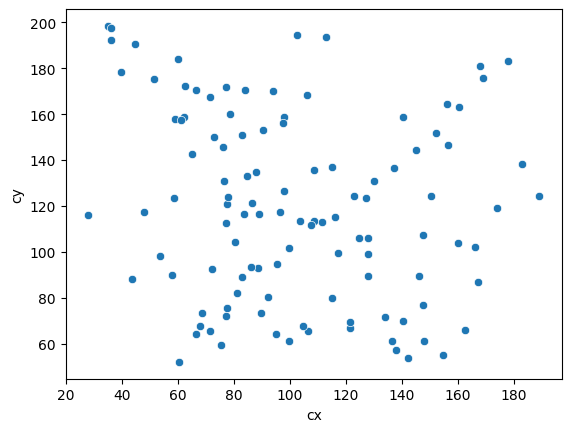

In [18]:
sns.scatterplot(data=data, x="cx", y="cy")
# Save the plot
plt.savefig('Distribution.png')

# Show the plot (optional)
plt.show()

here we can observer that samples have covered most of the detection region to establish the generalised approaximations in model training. it could have been better we apply some sort of augmentation to enahnce the diversity and varience in data

**box size distribution**

In [19]:
import pandas as pd

def cm(xmin, ymin, xmax, ymax):
    w = xmax - xmin
    h = ymax - ymin
    return (h+w)/2

# Assuming 'data' is a DataFrame with columns [1, 2, 3, 4]
data['size'] = data.apply(lambda r: cm(r[1], r[2], r[3], r[4]), axis=1)


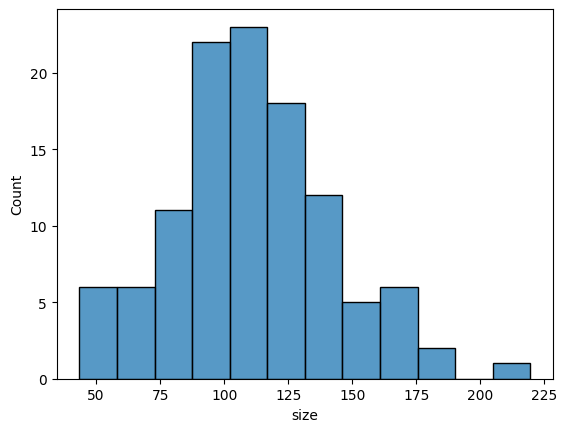

In [20]:
sns.histplot(data['size'])
# Save the plot
plt.savefig('box-size-distribution.png')

# Show the plot (optional)
plt.show()

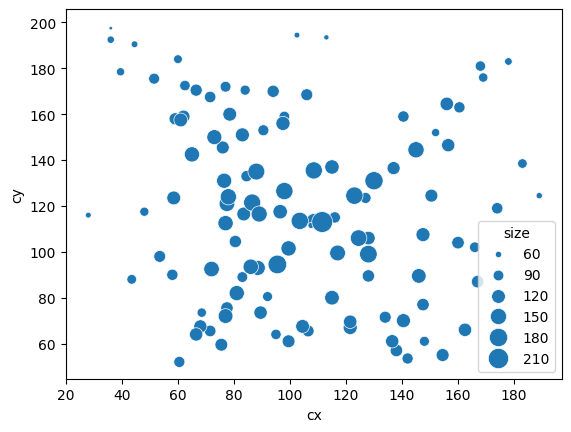

In [21]:
sns.scatterplot(data=data, x="cx", y="cy", size = 'size', sizes=(0, 224))
# Save the plot
plt.savefig('size-location.png')

# Show the plot (optional)
plt.show()

# Pre Processing

In [22]:
def proc_image(path, xmin, ymin, xmax, ymax):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float64)
    return image/255.0, (xmin, ymin, xmax, ymax)

In [23]:
np.random.seed(127)
bs = 16 #batch size
valid_mask = np.random.rand(len(data)) < 0.2
val = data[valid_mask]
train = data[~valid_mask]

In [24]:
dataset = tf.data.Dataset.from_tensor_slices((train[0].values, train[1].values, train[2].values ,train[3].values, train[4].values))
dataset = dataset.map(proc_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset = dataset.shuffle(241).cache().repeat().batch(bs).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

dataset_valid = tf.data.Dataset.from_tensor_slices((val[0].values, val[1].values, val[2].values, val[3].values, val[4].values))
dataset_valid = dataset_valid.map(proc_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset_valid = dataset_valid.shuffle(241).cache().batch(bs).repeat().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

steps_per_epoch_train = len(train) // bs
validation_steps = len(val) // bs

visulise data loader

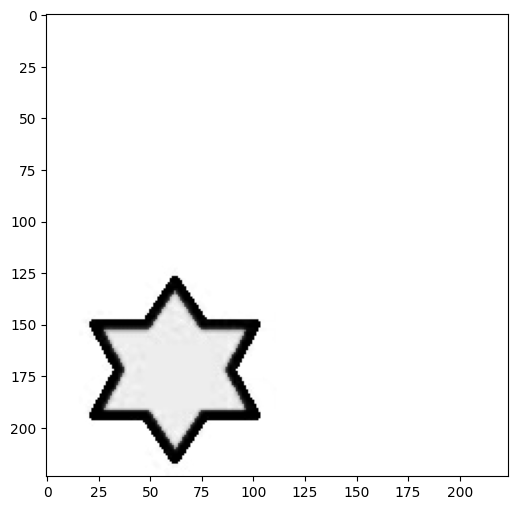

In [25]:
tf.keras.backend.clear_session()
datasetGen = iter(dataset)
batch2 = next(datasetGen)
img = np.array(batch2[0][0],dtype='float32')
# print(np.array(batch2[1],dtype='float32'))
plt.figure(figsize=(6,6))
plt.imshow(img[:,:,0],cmap='gray')

# Models

In [26]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Function to create simple ANN model
def create_ann_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(224, 224, 3)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation="linear")
    ])
    return model





In [27]:
def create_cnn_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3)),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation="linear")
    ])
    return model



In [28]:
# Function to create simple DNN model
def create_dnn_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(224, 224, 3)),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation="linear")
    ])
    return model



In [39]:
# Function to create simple LSTM model
def create_lstm_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Reshape((224, 224*3), input_shape=(224, 224, 3)),  # Reshape to (224, 224*3) assuming 3 channels
        tf.keras.layers.LSTM(128),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation="linear")
    ])
    return model


In [42]:
# Function to create simple RNN model
def create_rnn_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Reshape((224, 224*3), input_shape=(224, 224, 3)),  # Reshape to (224, 224*3) assuming 3 channels
        tf.keras.layers.SimpleRNN(128),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation="linear")
    ])
    return model


# Training and Testing

In [33]:
# Compile and train model
def train_model(model, train_dataset, val_dataset, epochs, steps_per_epoch, validation_steps):
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    history = model.fit(train_dataset, epochs=epochs, steps_per_epoch=steps_per_epoch, validation_data=val_dataset, validation_steps=validation_steps)
    return history


# Plot and save loss and accuracy
def plot_and_save_metrics(history, model_type):
    # Plot loss
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss - ' + model_type)
    plt.legend()
    plt.savefig(model_type + '_loss.png')
    plt.show()

    # Plot accuracy
    plt.plot(history.history['mae'], label='train_mae')
    plt.plot(history.history['val_mae'], label='val_mae')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Error')
    plt.title('Mean Absolute Error - ' + model_type)
    plt.legend()
    plt.savefig(model_type + '_mae.png')
    plt.show()



Epoch 1/50
5/5 [==============================] - 3s 435ms/step - loss: 49733.9453 - mae: 149.9720 - val_loss: 1644.0210 - val_mae: 35.0331
Epoch 2/50
5/5 [==============================] - 3s 514ms/step - loss: 2130.8188 - mae: 39.1653 - val_loss: 805.5683 - val_mae: 24.1443
Epoch 3/50
5/5 [==============================] - 2s 342ms/step - loss: 1782.4730 - mae: 33.9855 - val_loss: 1527.4417 - val_mae: 33.5884
Epoch 4/50
5/5 [==============================] - 2s 333ms/step - loss: 1836.5602 - mae: 38.6157 - val_loss: 723.5010 - val_mae: 22.6761
Epoch 5/50
5/5 [==============================] - 2s 329ms/step - loss: 1652.0192 - mae: 32.7315 - val_loss: 818.2024 - val_mae: 23.0894
Epoch 6/50
5/5 [==============================] - 2s 328ms/step - loss: 1462.5037 - mae: 33.1374 - val_loss: 687.0244 - val_mae: 21.4304
Epoch 7/50
5/5 [==============================] - 2s 320ms/step - loss: 1252.9652 - mae: 29.2508 - val_loss: 831.6190 - val_mae: 22.9807
Epoch 8/50
5/5 [=====================

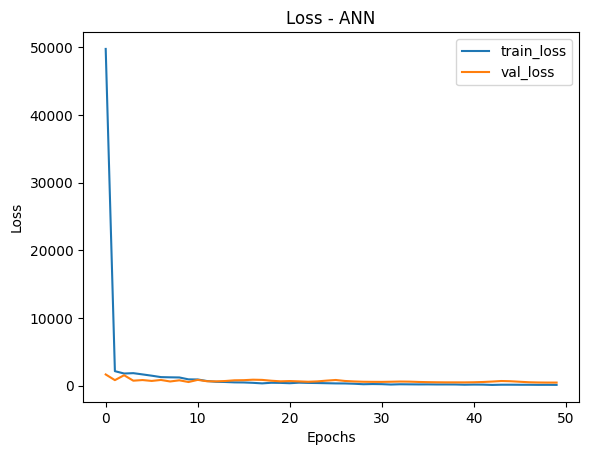

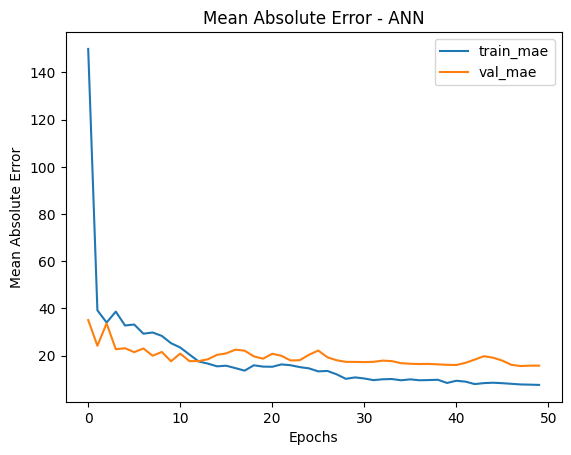

In [35]:
# Train and evaluate ANN model
ann_model = create_ann_model()
ann_history = train_model(ann_model, dataset, dataset_valid, epochs=50, steps_per_epoch=steps_per_epoch_train, validation_steps=validation_steps)
plot_and_save_metrics(ann_history, 'ANN')

Epoch 1/50
5/5 [==============================] - 18s 4s/step - loss: 2448.3848 - mae: 39.6567 - val_loss: 787.5180 - val_mae: 24.0266
Epoch 2/50
5/5 [==============================] - 9s 2s/step - loss: 1778.2379 - mae: 33.4434 - val_loss: 1374.8867 - val_mae: 31.7186
Epoch 3/50
5/5 [==============================] - 9s 2s/step - loss: 1495.2468 - mae: 33.9589 - val_loss: 510.8860 - val_mae: 18.5485
Epoch 4/50
5/5 [==============================] - 10s 2s/step - loss: 683.1439 - mae: 19.5388 - val_loss: 454.5175 - val_mae: 14.5004
Epoch 5/50
5/5 [==============================] - 11s 2s/step - loss: 322.7522 - mae: 13.6326 - val_loss: 352.9762 - val_mae: 13.3998
Epoch 6/50
5/5 [==============================] - 9s 2s/step - loss: 352.1055 - mae: 14.3442 - val_loss: 288.2514 - val_mae: 12.4462
Epoch 7/50
5/5 [==============================] - 13s 3s/step - loss: 206.0597 - mae: 11.1530 - val_loss: 228.3736 - val_mae: 12.7063
Epoch 8/50
5/5 [==============================] - 12s 3s/step

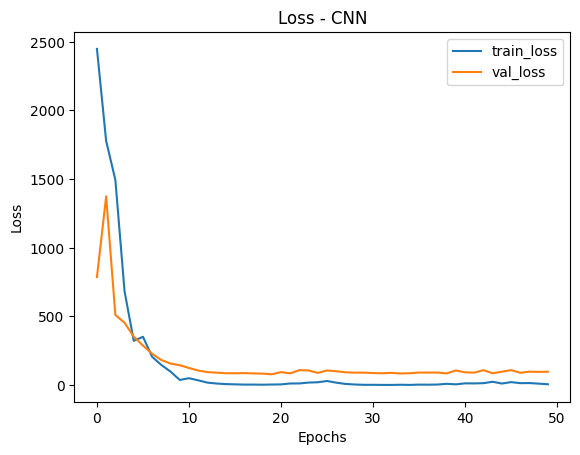

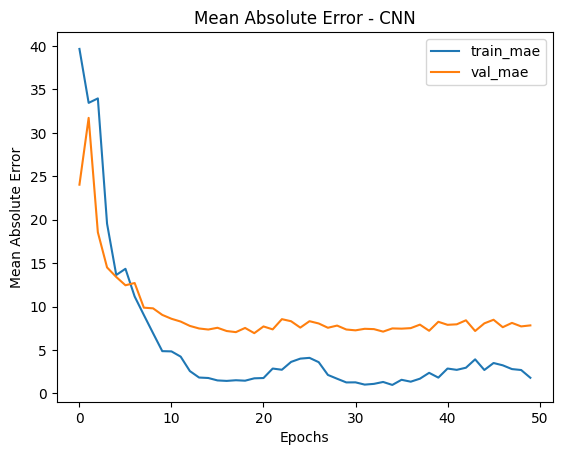

In [36]:
cnn_model = create_cnn_model()
cnn_history = train_model(cnn_model, dataset, dataset_valid, epochs=50, steps_per_epoch=steps_per_epoch_train, validation_steps=validation_steps)
plot_and_save_metrics(cnn_history, 'CNN')



Epoch 1/50
5/5 [==============================] - 6s 1s/step - loss: 34221.2539 - mae: 118.7619 - val_loss: 1306.6008 - val_mae: 31.0101
Epoch 2/50
5/5 [==============================] - 4s 687ms/step - loss: 1980.2308 - mae: 34.8069 - val_loss: 915.0782 - val_mae: 24.8136
Epoch 3/50
5/5 [==============================] - 3s 660ms/step - loss: 1819.7764 - mae: 33.5458 - val_loss: 1189.2520 - val_mae: 28.8629
Epoch 4/50
5/5 [==============================] - 3s 658ms/step - loss: 1549.6250 - mae: 29.8217 - val_loss: 2111.7422 - val_mae: 38.9661
Epoch 5/50
5/5 [==============================] - 5s 1s/step - loss: 1574.2644 - mae: 30.6639 - val_loss: 1956.7495 - val_mae: 37.3138
Epoch 6/50
5/5 [==============================] - 3s 655ms/step - loss: 1233.2859 - mae: 26.4004 - val_loss: 1583.3079 - val_mae: 32.1900
Epoch 7/50
5/5 [==============================] - 3s 662ms/step - loss: 1168.4636 - mae: 26.7761 - val_loss: 953.2608 - val_mae: 22.3754
Epoch 8/50
5/5 [========================

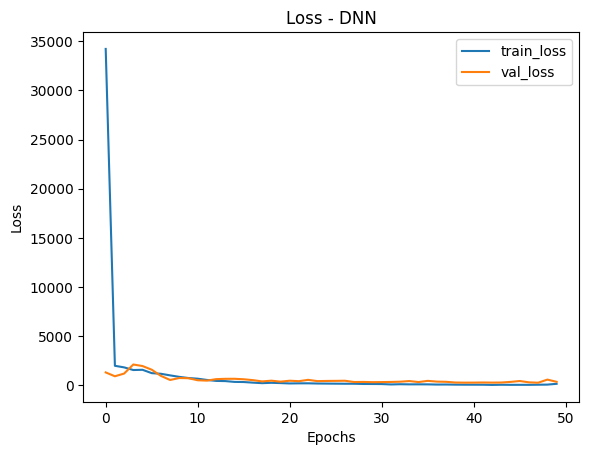

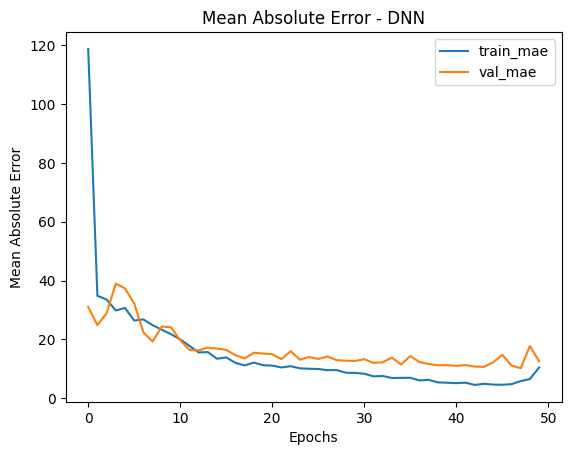

In [37]:
# Train and evaluate DNN model
dnn_model = create_dnn_model()
dnn_history = train_model(dnn_model, dataset, dataset_valid, epochs=50, steps_per_epoch=steps_per_epoch_train, validation_steps=validation_steps)
plot_and_save_metrics(dnn_history, 'DNN')



Epoch 1/50
5/5 [==============================] - 6s 548ms/step - loss: 4332.6846 - mae: 50.8302 - val_loss: 2086.8181 - val_mae: 36.4607
Epoch 2/50
5/5 [==============================] - 3s 636ms/step - loss: 3878.1887 - mae: 45.8173 - val_loss: 1932.4192 - val_mae: 34.7994
Epoch 3/50
5/5 [==============================] - 2s 352ms/step - loss: 3932.9382 - mae: 46.7198 - val_loss: 1794.5331 - val_mae: 33.3172
Epoch 4/50
5/5 [==============================] - 2s 349ms/step - loss: 3450.6941 - mae: 42.2571 - val_loss: 1672.6119 - val_mae: 32.2968
Epoch 5/50
5/5 [==============================] - 2s 356ms/step - loss: 3426.4988 - mae: 41.8699 - val_loss: 1548.6584 - val_mae: 31.2123
Epoch 6/50
5/5 [==============================] - 2s 347ms/step - loss: 3149.0376 - mae: 40.1630 - val_loss: 1422.7568 - val_mae: 30.0150
Epoch 7/50
5/5 [==============================] - 2s 344ms/step - loss: 3040.2234 - mae: 40.6473 - val_loss: 1309.0945 - val_mae: 28.8262
Epoch 8/50
5/5 [==================

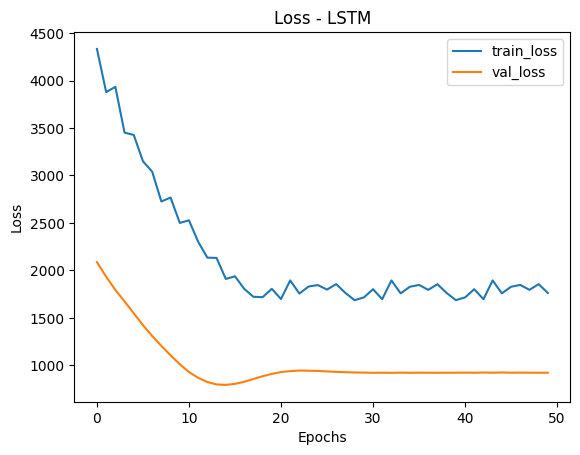

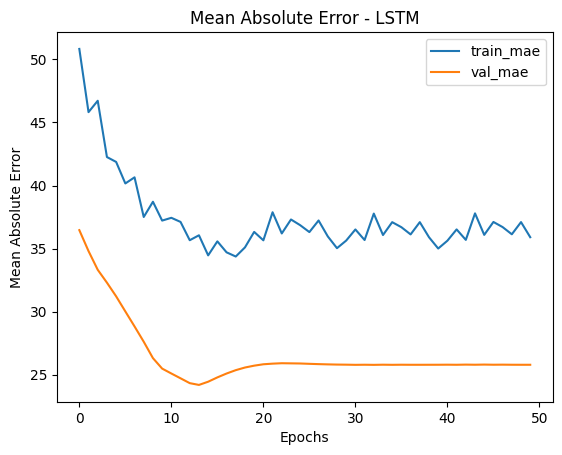

In [40]:
# Train and evaluate LSTM model
lstm_model = create_lstm_model()
lstm_history = train_model(lstm_model, dataset, dataset_valid, epochs=50, steps_per_epoch=steps_per_epoch_train, validation_steps=validation_steps)
plot_and_save_metrics(lstm_history, 'LSTM')



Epoch 1/50
5/5 [==============================] - 4s 342ms/step - loss: 4042.7310 - mae: 48.3220 - val_loss: 1695.5544 - val_mae: 32.4890
Epoch 2/50
5/5 [==============================] - 1s 242ms/step - loss: 3324.6587 - mae: 41.1912 - val_loss: 1492.8391 - val_mae: 30.6948
Epoch 3/50
5/5 [==============================] - 1s 242ms/step - loss: 3283.0386 - mae: 42.0102 - val_loss: 1330.3291 - val_mae: 29.0576
Epoch 4/50
5/5 [==============================] - 1s 128ms/step - loss: 2799.4746 - mae: 37.8400 - val_loss: 1191.6454 - val_mae: 27.4503
Epoch 5/50
5/5 [==============================] - 1s 124ms/step - loss: 2721.4531 - mae: 37.7790 - val_loss: 1068.2734 - val_mae: 25.8688
Epoch 6/50
5/5 [==============================] - 1s 131ms/step - loss: 2437.0906 - mae: 36.1167 - val_loss: 964.5764 - val_mae: 25.2696
Epoch 7/50
5/5 [==============================] - 1s 122ms/step - loss: 2278.8877 - mae: 36.1504 - val_loss: 883.9755 - val_mae: 24.8243
Epoch 8/50
5/5 [====================

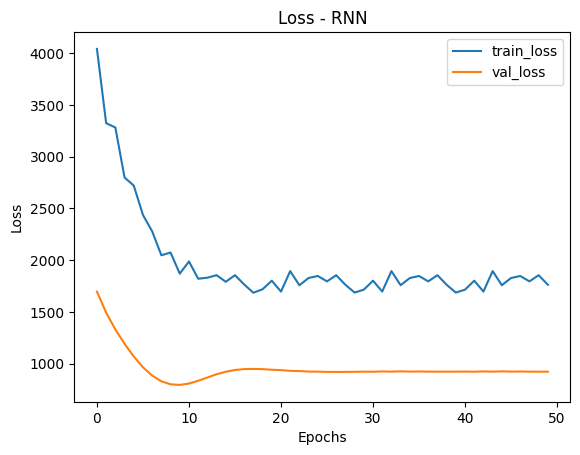

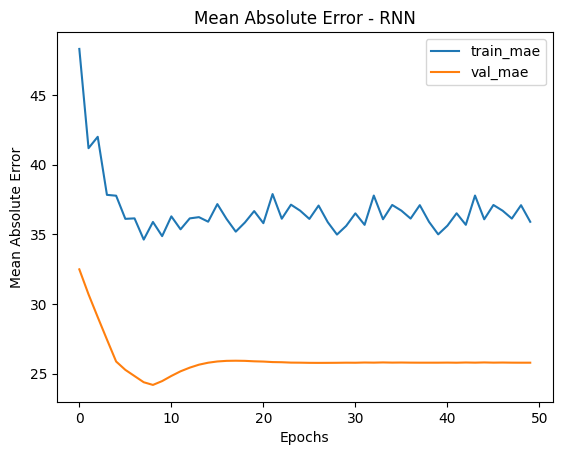

In [43]:
# Train and evaluate RNN model
rnn_model = create_rnn_model()
rnn_history = train_model(rnn_model, dataset, dataset_valid, epochs=50, steps_per_epoch=steps_per_epoch_train, validation_steps=validation_steps)
plot_and_save_metrics(rnn_history, 'RNN')

# Comparision

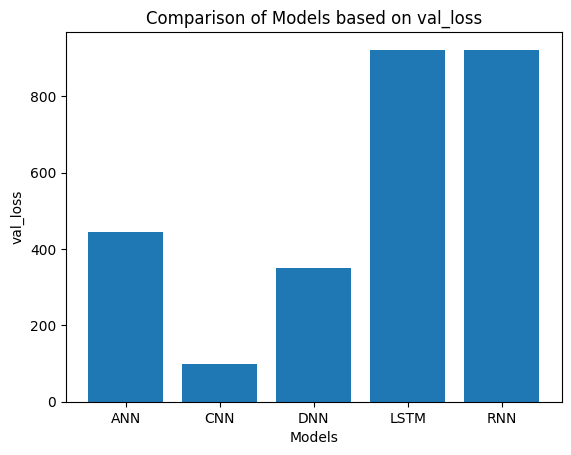

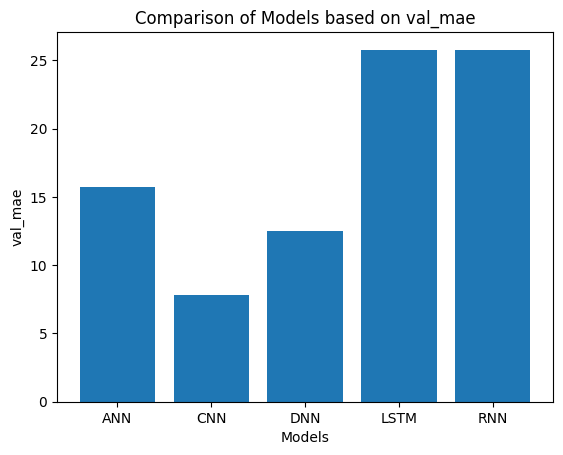

In [44]:
import matplotlib.pyplot as plt

def compare_models_metrics(models_history, metric):
    model_names = list(models_history.keys())
    metrics_values = [history.history[metric][-1] for history in models_history.values()]

    plt.bar(model_names, metrics_values)
    plt.xlabel('Models')
    plt.ylabel(metric)
    plt.title('Comparison of Models based on ' + metric)
    plt.savefig('comparison_bar_graph_' + metric + '.png')
    plt.show()

# Assume models_history is a dictionary containing histories of all five models
models_history = {'ANN': ann_history, 'CNN': cnn_history, 'DNN': dnn_history, 'LSTM': lstm_history, 'RNN': rnn_history}

# Compare models based on validation loss
compare_models_metrics(models_history, 'val_loss')

# Alternatively, you can compare based on other metrics like validation MAE
compare_models_metrics(models_history, 'val_mae')
